<a href="https://colab.research.google.com/github/KingYuanSun/Individual-Projects-Finance/blob/master/StockPrediction_Amazon_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Adapted by Carlos Toxtli http://www.carlostoxtli.com/#colab-stock-1

Credits: https://github.com/Kulbear/stock-prediction

In [353]:
!git clone https://github.com/Kulbear/stock-prediction
%cd stock-prediction

Cloning into 'stock-prediction'...
remote: Enumerating objects: 34, done.
remote: Total 34 (delta 0), reused 0 (delta 0), pack-reused 34
Unpacking objects: 100% (34/34), done.
/content/stock-prediction/stock-prediction/stock-prediction/stock-prediction/stock-prediction/stock-prediction/stock-prediction/stock-prediction/stock-prediction/stock-prediction/stock-prediction/stock-prediction/stock-prediction/stock-prediction/stock-prediction/stock-prediction/stock-prediction/stock-prediction/stock-prediction/stock-prediction/stock-prediction/stock-prediction/stock-prediction/stock-prediction/stock-prediction/stock-prediction


# Stock Prediction with Recurrent Neural Network

Deep learning is involved a lot in the modern quantitive financial field. There are many different neural networks can be applied to stock price prediction problems. The recurrent neural network, to be specific, the Long Short Term Memory(LSTM) network outperforms others architecture since it can take advantage of predicting time series (or sequentially) involved result with a specific configuration.

We will make a really simple LSTM with Keras to predict the stock price in the Chinese stock.

In [354]:
import time
import math
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import numpy as np
import pandas as pd
import sklearn.preprocessing as prep

## Import Data

I have introduced how we get this dataset both in README.md and in another notebook.

In [355]:
df = pd.read_csv('000002-from-1995-01-01.csv')
df.head()

,open,high,low,volume,amount,close
0,20.64,20.64,20.37,16362363.0,3.350027e+08,20.56
1,20.92,20.92,20.60,21850597.0,4.520071e+08,20.64
2,21.00,21.15,20.72,26910139.0,5.628396e+08,20.94
3,20.70,21.57,20.70,64585536.0,1.363421e+09,21.02
4,20.60,20.70,20.20,45886018.0,9.382043e+08,20.70


In [356]:
!pip install yfinance
import yfinance as yf
tickers = ['AMZN']
ohlc = yf.download(tickers, start="2001-1-1", end="2007-05-31") ## Probably Only works for stable stocks, not high potential stocks.
#ohlc = yf.download(tickers, start="2008-1-1", end="2013-05-31")
#print (ohlc)
print(list(ohlc.columns.values))
# ohlc.head()
ohlc_reversed = ohlc.sort_values(['Date'], ascending=[False])
ohlc_reversed = ohlc_reversed.reindex(columns=['Open', 'High', 'Low', 'Volume','Adj Close', 'Close'])
ohlc_reversed.drop('Adj Close', axis=1, inplace=True)
print (ohlc_reversed)

print (df)

df = ohlc_reversed


[*********************100%***********************]  1 of 1 completed
['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
                 Open       High        Low    Volume      Close
Date                                                            
2007-05-30  69.059998  70.080002  68.860001  10576100  69.860001
2007-05-29  68.430000  69.779999  67.720001  11730800  69.629997
2007-05-25  69.690002  69.699997  68.250000   9987200  68.550003
2007-05-24  69.040001  70.419998  67.709999  23824600  69.349998
2007-05-23  69.209999  73.309998  68.790001  42582500  69.000000
...               ...        ...        ...       ...        ...
2001-01-08  14.437500  15.562500  13.750000  10444700  14.937500
2001-01-05  15.500000  15.875000  13.562500   8798800  14.562500
2001-01-04  17.000000  17.562500  15.437500  10620500  15.500000
2001-01-03  13.625000  17.875000  13.562500  14680400  17.562500
2001-01-02  15.812500  16.000000  13.625000   9203500  13.875000

[1609 rows x 5 columns]
     

## Preprocess Data

We can see from the table above that the scales of our features vary a lot. It will be beneficial to normalize your training data before you feed data into your model. "Having different features with widely different scales fed to your model will cause the network to weight the features not equally. This can cause a falsely prioritisation of some features over the others in the representation." Read [here](http://stackoverflow.com/a/43526354/6670143) for more detailed explanation.

In [357]:
def standard_scaler(X_train, X_test):
    train_samples, train_nx, train_ny = X_train.shape
    test_samples, test_nx, test_ny = X_test.shape
    
    X_train = X_train.reshape((train_samples, train_nx * train_ny))
    X_test = X_test.reshape((test_samples, test_nx * test_ny))
    
    preprocessor = prep.StandardScaler().fit(X_train)
    X_train = preprocessor.transform(X_train)
    X_test = preprocessor.transform(X_test)
    
    X_train = X_train.reshape((train_samples, train_nx, train_ny))
    X_test = X_test.reshape((test_samples, test_nx, test_ny))
    
    return X_train, X_test

Split the data to X_train, y_train, X_test, y_test

In [358]:
def preprocess_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.values
    
    sequence_length = seq_len + 1
    result = []
    ## Probably here add another column as the label.
    for index in range(len(data) - sequence_length):
        result.append(data[index : index + sequence_length])
        
    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[: int(row), :]

    # print (result)
    # print (row)
    print (train[:, : -1])
    print (train[:, -1][: ,-1]) 

    print (result[int(row) :, -1][ : ,-1]) 

    train, result = standard_scaler(train, result)
    
    X_train = train[:, : -1]
    y_train = train[:, -1][: ,-1]
    X_test = result[int(row) :, : -1]
    y_test = result[int(row) :, -1][ : ,-1]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features)) 

 

    return [X_train, y_train, X_test, y_test]

## Build the LSTM Network

Here we will build a simple RNN with 2 LSTM layers.
The architecture is:
    
    LSTM --> Dropout --> LSTM --> Dropout --> Fully-Conneted(Dense)

In [359]:
def build_model(layers):

    model = Sequential()
    model.add(LSTM(512, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(Dropout(0.4))
    model.add(LSTM(256, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(32))
    model.add(Dense(1, activation='linear'))

    start = time.time()
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    model.summary() 
    print("Compilation Time : ", time.time() - start)
    return model

In [360]:
window = 15
X_train, y_train, X_test, y_test = preprocess_data(df[:: -1], window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)
# print (X_train)
# print (y_train)
# print (X_test)
# print (y_test)

[[[1.58125000e+01 1.60000000e+01 1.36250000e+01 9.20350000e+06
   1.38750000e+01]
  [1.36250000e+01 1.78750000e+01 1.35625000e+01 1.46804000e+07
   1.75625000e+01]
  [1.70000000e+01 1.75625000e+01 1.54375000e+01 1.06205000e+07
   1.55000000e+01]
  ...
  [2.03750000e+01 2.03750000e+01 1.86875000e+01 6.17750000e+06
   1.99375000e+01]
  [1.95000000e+01 1.99375000e+01 1.85000000e+01 4.39860000e+06
   1.85000000e+01]
  [1.83750000e+01 1.93125000e+01 1.82500000e+01 4.74430000e+06
   1.89531250e+01]]

 [[1.36250000e+01 1.78750000e+01 1.35625000e+01 1.46804000e+07
   1.75625000e+01]
  [1.70000000e+01 1.75625000e+01 1.54375000e+01 1.06205000e+07
   1.55000000e+01]
  [1.55000000e+01 1.58750000e+01 1.35625000e+01 8.79880000e+06
   1.45625000e+01]
  ...
  [1.95000000e+01 1.99375000e+01 1.85000000e+01 4.39860000e+06
   1.85000000e+01]
  [1.83750000e+01 1.93125000e+01 1.82500000e+01 4.74430000e+06
   1.89531250e+01]
  [1.91875000e+01 2.23750000e+01 1.90000000e+01 1.38481000e+07
   2.18750000e+01]]



In [361]:
model = build_model([X_train.shape[2], window, 100, 1])

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_125 (LSTM)              (None, 15, 512)           1060864   
_________________________________________________________________
dropout_100 (Dropout)        (None, 15, 512)           0         
_________________________________________________________________
lstm_126 (LSTM)              (None, 15, 256)           787456    
_________________________________________________________________
dropout_101 (Dropout)        (None, 15, 256)           0         
_________________________________________________________________
lstm_127 (LSTM)              (None, 15, 128)           197120    
_________________________________________________________________
dropout_102 (Dropout)        (None, 15, 128)           0         
_________________________________________________________________
lstm_128 (LSTM)              (None, 15, 64)          

## Training the Network

You can play with the hyperparameters here. The training process can take a significant time if you are using a average GPU or CPU(worse!).

In [362]:
model.fit(
    X_train,
    y_train,
    batch_size=768,
    epochs=300,
    validation_split=0.1,
    verbose=0)

In [363]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 0.01 MSE (0.08 RMSE)
Test Score: 0.04 MSE (0.19 RMSE)


## Visualize the Prediction

In [364]:
diff = []
ratio = []
pred = model.predict(X_test)
for u in range(len(y_test)):
    pr = pred[u][0]
    ratio.append((y_test[u] / pr) - 1)
    diff.append(abs(y_test[u] - pr))

print (pred)
print (y_test)

[[0.1406599 ]
 [0.18085553]
 [0.18398438]
 [0.16408226]
 [0.14303578]
 [0.14429365]
 [0.14708588]
 [0.13690965]
 [0.12206028]
 [0.1110168 ]
 [0.1100563 ]
 [0.11649729]
 [0.18585262]
 [0.49234205]
 [0.650491  ]
 [0.65947086]
 [0.633935  ]
 [0.6044782 ]
 [0.5741662 ]
 [0.5444056 ]
 [0.51650274]
 [0.49837512]
 [0.49186173]
 [0.5072059 ]
 [0.54698646]
 [0.5886635 ]
 [0.62000597]
 [0.684879  ]
 [0.8124631 ]
 [0.920543  ]
 [0.9102515 ]
 [0.8485264 ]
 [0.8052044 ]
 [0.8075993 ]
 [0.8277537 ]
 [0.7820414 ]
 [0.7410167 ]
 [0.7380315 ]
 [0.7589454 ]
 [0.73648936]
 [0.68458056]
 [0.6724326 ]
 [0.66264325]
 [0.6275083 ]
 [0.60240513]
 [0.6051515 ]
 [0.6145482 ]
 [0.62273234]
 [0.6382529 ]
 [0.68460494]
 [0.71828425]
 [0.6912274 ]
 [0.6742636 ]
 [0.68010944]
 [0.6912893 ]
 [0.6824513 ]
 [0.676372  ]
 [0.6747265 ]
 [0.6673571 ]
 [0.6104145 ]
 [0.6104687 ]
 [0.62794167]
 [0.6076406 ]
 [0.5778088 ]
 [0.54590523]
 [0.5342185 ]
 [0.54994965]
 [0.5830543 ]
 [0.602699  ]
 [0.557388  ]
 [0.510243  ]
 [0.49

In [365]:
# TODO: Scale it back

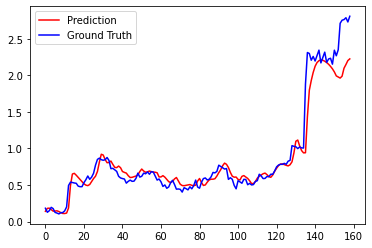

In [366]:
# if using within a jupyter notebook
%matplotlib inline 

import matplotlib
import matplotlib.pyplot as plt2

plt2.plot(pred, color='red', label='Prediction')
plt2.plot(y_test, color='blue', label='Ground Truth')
plt2.legend(loc='upper left')
plt2.show()